In [2]:
!pip install pytorch-model-summary
from pytorch_model_summary import summary

# Main model

In [3]:
import torch
import numpy as np
from torch import nn, Tensor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import List, Tuple, Dict
import seaborn as sns

class MLP(nn.Module):
    """ Multilayer Perceptron (MLP) with n layers and fixed activation after each hidden
    layer, with linear output layer.

    Parameters
    ----------
    in_channels: Number of channels in input.
    out_channels: Number of output channels.
    n_layers: Number of layers including output layer.
    hidden_size: Size of each hidden layer.
    activation: Activation after each hidden layer.
    """

    def __init__(self,
        in_channels: int, 
        out_channels: int, 
        n_layers: int, 
        hidden_size: int = 32, 
        activation: nn.Module = nn.ReLU,
    ):
        assert n_layers >= 3
        super().__init__()

        layers = [nn.Linear(in_channels, hidden_size), activation()]  # first layer
        for _ in range(n_layers-2):  # intermediate layers
            layers.extend( [nn.Linear(hidden_size, hidden_size), activation()])
        layers.extend([nn.Linear(hidden_size, out_channels)])  # last layer
    
        self.mlp = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        return self.mlp(x)


class Permutation(nn.Module):
    """ A permutation layer.

    Parameters
    ----------
    in_channels: Number of channels to be permuted.
    """

    def __init__(self, in_channels: int):
        super().__init__()
        self.in_channels = in_channels
        self.register_buffer('p', torch.randperm(in_channels))
        self.register_buffer('invp', torch.argsort(self.p))

    def forward(self, x: Tensor) -> Tensor:
        assert x.shape[-1] == self.in_channels
        return x[:, self.p]

    def backward(self, x: Tensor) -> Tensor:
        assert x.shape[-1] == self.in_channels
        return x[:, self.invp]


class RealNVPLayer(nn.Module):
    """ Single layer of Real non-volume preserving (NVP) transform.
    Uses a multilayer perceptron (MLP) to transform half input channels into scaling and
    translation vectors to be used on remaining half.

    Parameters
    ----------
    in_channels: Number of channels of input.
    n_layers: Number of layers in MLP.
    activation: Activation of first (n_layers-1) layers (default ReLU).
    """

    def __init__(
        self, 
        in_channels: int, 
        n_layers: int = 3, 
        activation: nn.Module = nn.ReLU,
        ):
        super().__init__()
        assert in_channels%2 == 0, "Should have even dims"

        self.mlp = MLP(
            in_channels=in_channels//2, 
            out_channels=in_channels, 
            n_layers=n_layers, 
            hidden_size=in_channels//2,
            activation=activation,
            )
    
    def forward(self, x: Tensor) -> Tensor:
        """Splits x into two halves (x0, x1), maps x0 through MLP to form s and t, 
        then returns (s*x1+t, x0).
        """
        # split
        x0, x1 = torch.chunk(x, chunks=2, dim=-1)

        st = self.mlp(x0)

        # scale and translate
        s, t = torch.chunk(st, chunks=2, dim=-1)
        s =  .1 * torch.tanh(s)  # squash s
        transformed = x1 * torch.exp(s) + t
        y = torch.cat([transformed, x0], axis=-1)
        return y


class RealNVPBlock(nn.Module):
    """Real Non-volume preserving (NVP) block, consisting of n_layers layers.

    Parameters
    ----------
    in_channels: Number of channels of input.
    n_layers: Number of layers in each block.
    """

    def __init__(self, in_channels: int, n_layers: int = 2):
        super().__init__()
        self.in_channels = in_channels
        self.n_layers = n_layers
        self.nvp = nn.Sequential(
            *[RealNVPLayer(in_channels) for _ in range(n_layers)]
            )
    
    def forward(self, x: Tensor) -> Tensor:
        return self.nvp(x)


class RealNVP(nn.Module):
    """ Real (non-volume preserving) NVP model (forward only).

    Parameters
    ----------
    in_channels: Size of NVP input. Half will remain untouched.
    n_blocks: Number of NVP blocks.
    n_layers: Number of layers within each NVP block.
    """

    def __init__(self, in_channels: int, n_blocks: int, n_layers: int):
        super().__init__()
        blocks = [RealNVPBlock(in_channels, n_layers)]

        for _ in range(n_blocks-1):
            blocks.extend([
                           Permutation(in_channels), 
                           RealNVPBlock(in_channels, n_layers)
                           ]
            )

        self.nvp = nn.Sequential(*blocks)
    
    def forward(self, x: Tensor) -> Tensor:
        """Run n_blocks of NVP"""
        return self.nvp(x)


def lift(
    x: Tensor, 
    out_channels: int, 
    nvp_blocks: int, 
    nvp_layers: int
    ) -> Tensor:
    """ Nonlinearly transform x from lo -> hi dim w/ random-initialized MLP and realNVP.
    MLP lifts from in_channels to out_channels, then realNVP further transforms the 
    data.
    
    Parameters
    ----------
    x: Input Tensor with Size([n, in_channels])
    out_channels: Dimensionality of output.
    nvp_blocks: Number of NVP blocks in NVP model.
    nvp_layers: Number of layers within each NVP block.

    Returns
    -------
    y: Output Tensor with size Size([n, out_channels]).
    """

    in_channels = x.shape[-1]
    mlp = MLP(in_channels, out_channels-in_channels, n_layers=3, activation=nn.ReLU).requires_grad_(False)
    realnvp_model = RealNVP(out_channels, nvp_blocks, nvp_layers).requires_grad_(False)
    
    # fill ambient space
    x_append = mlp(x)  
    y = torch.cat([x, x_append], -1)
    y = realnvp_model(y)  
    return y


def simulate_data_discrete(
    n_samples: int, 
    n_cls: int, 
    n_dim: int
    ) -> Tuple[Tensor, Tensor, Tensor, Tensor, Tensor]:
    """ Create n-dimensional data with 2D intrinsic dimensionality.

    Parameters
    ----------
    n_samples: Number of samples.
    n_cls: Number of discrete classes.
    n_dim: Dimensionality of data.

    Returns
    -------
    x_true: Data to be used, Size([n_samples, n_dim]).
    z_true: True 2D data, Size([n_samples, 2]).
    u_true: Condition labels with n_cls unique classes, Size([n_samples, ]).
    lam_true: Poisson rate parameter of each sample, Size([n_samples, n_dim]).
    """

    mu_true = torch.empty((2, n_cls)).uniform_(-5, 5)
    var_true = torch.empty((2, n_cls)).uniform_(.5, 3)
    u_true = torch.tile(torch.arange(n_cls), (n_samples//n_cls, ))

    z0 = torch.normal(mu_true[0][u_true], np.sqrt(var_true[0][u_true]))
    z1 = torch.normal(mu_true[1][u_true], np.sqrt(var_true[1][u_true]))
    z_true = torch.stack([z0, z1], -1)

    ## Nonlinearly lift from 2D up to n_dims using RealNVP
    mean_true = lift(z_true, n_dim, nvp_blocks=4, nvp_layers=2)
    lam_true = torch.exp(2*torch.tanh(mean_true))  # Poisson rate param
    x_true = torch.poisson(lam_true)
    return x_true, z_true, u_true, lam_true


def simulate_data_continuous(n_samples: int, n_dim: int) -> torch.Tensor:
    """TODO: docstring. Haven't validated yet."""
    ## true 2D latent

    u_true = torch.empty((n_samples, )).uniform_(0, 2*np.pi)
    mu_true = torch.stack([u_true, 2*torch.sin(u_true)], -1)
    var_true = .15 * torch.abs(mu_true)
    var_true[:,0] = .6 - var_true[:,1]

    z_true = torch.randn((n_samples, 2)) * torch.sqrt(var_true) + mu_true

    mean_true = lift(z_true, n_dim, nvp_blocks=4, nvp_layers=2)
    lam_true = torch.exp(2.2 * torch.tanh(mean_true))
    x_true = torch.poisson(lam_true)

    return x_true, z_true, u_true, lam_true


class ZPriorDiscrete(nn.Module):
    """Learnable Lambda mean and var params for condition prior.
    Uses embedding matrices  (look-up tables). Assumes Normal-distributed latent z.

    Parameters
    ----------
    z_dim:  Dimensionality of latent variable.
    u_dim:  Number of unique classes/condition labels.
    """

    def __init__(self, u_dim: int, z_dim: int):
        super().__init__()
        self.z_dim = z_dim
        self.u_dim = u_dim

        self.embed_mean = nn.Embedding(u_dim, z_dim)
        self.embed_log_var = nn.Embedding(u_dim, z_dim)

    def forward(self, u: Tensor) -> Tuple[Tensor, Tensor]:
        """Returns mean and logvar of each sample. """
        lam_mean = self.embed_mean(u)
        lam_log_var = self.embed_log_var(u)
        return lam_mean, lam_log_var


class ZPriorContinuous(nn.Module):
    """ Map continuous u using MLP to a mean and logvar.
    Uses a single MLP to output both the mean and logvar of z label prior.

    Parameters
    ----------
    u_dim: Dimensionality of condition/label u.
    z_dim: Dimensionality of latent z.
    n_layers: Number of layers in MLP.
    hidden_size: Number of units in each hidden layer.
    activation: Activation of each hiden layer defaults to nn.Tanh().
    """

    def __init__(
        self, 
        u_dim: int, 
        z_dim: int, 
        n_layers: int = 3, 
        hidden_size: int = 32, 
        activation: nn.Module = nn.Tanh
        ):
        super().__init__()
        self.mlp = MLP(u_dim, 2*z_dim, n_layers, hidden_size, activation)

    def forward(self, u: Tensor) -> Tuple[Tensor, Tensor]:
        z = self.mlp(u)
        lam_mean, lam_log_var = torch.chunk(z, 2, -1)
        return lam_mean, lam_log_var


class Encoder(nn.Module):
    """ Recognition model determining mean and log_var of q(z|x)
    Goes from high-dim x down to mean and logvar of low-dim latent z. 
    This is done using a single MLP with both mean and logvar as outputs.

    Parameters
    ----------
    x_dim: Dimensionality of ovserved x.
    z_dim: Dimensionality of latent z.
    n_layers: Number of layers in MLP.
    hidden_size: Number of units per hidden layer.
    activation: Activation function for each hidden layer of MLP.
    """

    def __init__(
        self, 
        x_dim: int, 
        z_dim: int, 
        n_layers: int = 4, 
        hidden_size: int = 64, 
        activation: nn.Module = nn.Tanh
        ):
        super().__init__()
        # self.mlp = MLP(x_dim, 2*z_dim, n_layers, hidden_size, activation)
        self.mlp_mu = MLP(x_dim, z_dim, n_layers, hidden_size, activation)
        self.mlp_sig = MLP(x_dim, z_dim, n_layers, hidden_size, activation)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        """Go from x down to mean and logvar of z"""
        # y = self.mlp(x)
        # mean, log_var = torch.chunk(y, 2, -1)
        mean, log_var = self.mlp_mu(x), self.mlp_sig(x)
        return mean, log_var


class Decoder(nn.Module):
    """ Maps low-dim z to high-dim x by pushing through MLP then series of GIN blocks.

    p_f(x|z) = p_eps(x-f(z)) => x = f(z) + eps where eps is indep. noise
    f(z) nonlinearly lifts from z_dim to x_dim, then uses GIN blocks to map to mean
    firing rate of neurons.

    Parameters
    ----------
    z_dim: Dimensionality of latent variable z.
    x_dim: Dimensionality of observed data (should be much larger than that of z).
    n_gin_blocks: Number of GIN blocks.
    layers_per_gin: Number of MLP layers per GIN layer.
    layers_per_block: Number of GIN layers per block.
    hidden_size: Num units in each hidden layer in both MLP and GIN.
    lift_mlp_layers: Number of layers in MLP before GIN.
    obs_model: Observation model for x, either "poisson" or "gaussian".
    activation: Activation used in both MLP and GIN blocks.
    """

    def __init__(
        self, 
        z_dim: int, 
        x_dim: int, 
        n_gin_blocks: int, 
        layers_per_gin: int, 
        layers_per_block: int,
        hidden_size: int, 
        lift_mlp_layers: int = 3,
        obs_model: str = "poisson",
        activation: nn.Module = nn.ReLU,
        ):
        super().__init__()
        assert x_dim >= z_dim
        assert obs_model in ["poisson", "gaussian"]
        self.obs_model = obs_model

        hidden_size = max(hidden_size, x_dim//4)
        self.mlp = MLP(
            in_channels=z_dim, 
            out_channels=x_dim-z_dim,  # fill ambient space w/ nonlinear transform of z
            n_layers=lift_mlp_layers, 
            hidden_size=hidden_size, 
            activation=activation,
            )
        
        gin_blocks = []
        for _ in range(n_gin_blocks):
            gin_blocks.extend([Permutation(x_dim), 
              GINBlock(
                  in_channels=x_dim, 
                  layers_per_block=layers_per_block,
                  layers_per_gin=layers_per_gin, 
                  hidden_size=hidden_size,
                  activation=activation,
                  )])

        self.gin = nn.Sequential(*gin_blocks)
    
    def forward(self, z: Tensor) -> Tensor:
        """Lifts z up to the dimensionality of x via MLP, then pushes through a GIN.
        Passes through softplus if observation model is Poisson.
        """
        y = self.mlp(z)  # lift from z_dim to x_dim 
        x = torch.cat([z, y], -1)
        x = self.gin(x)
        return nn.functional.softplus(x) if self.obs_model == "poisson" else x


class GINBlock(nn.Module):
    """ General incompressible-flow network block.

    Parameters
    ----------
    in_channels: Dimensionality of input.
    layers_per_block: Number of affine coupling GIN layers per block.
    layers_per_gin: Number of MLP layers in affine coupling transform.
    hidden_size: Number of hidden units in each MLP layer of GIN affine coupling layer.
    activation: Activation function in each GIN MLP layer.
    """

    def __init__(
        self, 
        in_channels: int, 
        layers_per_block: int = 2, 
        layers_per_gin: int = 3, 
        hidden_size: int = 32,
        activation: nn.Module = nn.ReLU,
        ):
        super().__init__()
        assert in_channels % 2 == 0
        layers = [
                  GINLayer(
                      in_channels=in_channels, 
                      n_layers=layers_per_gin,  
                      hidden_size=hidden_size,
                      activation=activation,
                    )
                  for _ in range(layers_per_block)
                  ]
        self.gin = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        y = self.gin(x)
        return y


class GINLayer(nn.Module):
    """ Affine coupling General Incompessible-flow Network (GIN) layer.
    Same as RealNVP transform except determinant of Jacobian is set to 1. This is done 
    by ensuring the last entry of s is the neg sum of all other entries of s.

    Parameters
    ----------
    in_channels: Number of input channels.
    n_layers: Number of layers of MLP.
    hidden_size: Number of units in each hidden layer of MLP.
    activation: Activation function for each hideen layer of MLP.
    """

    def __init__(
        self, 
        in_channels: int, 
        n_layers: int = 3, 
        hidden_size: int = 32, 
        activation: nn.Module = nn.ReLU,
        ):
        super().__init__()
        assert n_layers >= 3
        assert in_channels % 2 == 0
        split_size = in_channels // 2

        self.split_size = split_size
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.mlp = MLP(
            in_channels=split_size, 
            out_channels=(2*split_size)-1, 
            n_layers=n_layers, 
            hidden_size=hidden_size, 
            activation=activation
            )

    def forward(self, x: Tensor) -> Tensor:
        """Affine coupling transform while preserving volume."""
        x0, x1 = torch.chunk(x, 2, -1)
        st = self.mlp(x0)
        n = st.shape[-1]

        s, t = st[..., :n//2], st[..., n//2:]
        s = .1*torch.tanh(s)  # squash
        s = torch.cat([s, -s.sum(axis=-1, keepdim=True)], -1)  # preserve volume

        transformed = (x1 * torch.exp(s)) + t
        y = torch.cat([transformed, x0], -1)
        return y


class PIVAE(nn.Module):
    """ Poisson Identifiable Variational Auto-Encoder

    Uses label prior to inform and facilitate identifiability in the latent space of a 
    VAE. More details can be found in original paper [0]. 

    Parameters
    ----------
    x_dim: 
        Dimensionality of observed data.
    z_dim: 
        Dimensionality of latent.
    u_dim: 
        Dimensionality of condition/label (if discrete, then # unique conditions).
    encoder_n_layers: 
        Number of MLP layers in Encoder mapping x to z.
    encoder_hidden_size: 
        Number of units in hidden layer of Encoder.
    decoder_n_blocks:  
        Number of GIN blocks in decoder.
    decoder_layers_per_gin_block: 
        Number of affine coupling layers in each GIN block.
    decoder_layers_per_gin: 
        Number of layers in each affine coupling layer.
    obs_model: 
        Observation model ("poisson", "gaussian").
    discrete_prior: 
        Whether or not label prior should be discrete (Default True).
    
    References
    ---------
    [0] Zhou, D., Wei, X. Learning identifiable and interpretable latent models of 
        high-dimensional neural activity using pi-VAE. NeurIPS 2020. 
        https://arxiv.org/abs/2011.04798 
    """

    def __init__( self, 
        x_dim: int,
        z_dim: int,
        u_dim: int,
        encoder_n_layers: int = 4,
        encoder_hidden_size: int = 64,
        decoder_n_blocks: int = 2,
        decoder_layers_per_gin_block: int = 3, 
        decoder_layers_per_gin: int = 3, 
        decoder_hidden_size: int = 32, 
        obs_model: str = "poisson", 
        discrete_prior: bool = True, 
    ):
        super().__init__() 

        self.obs_model = obs_model
        self.obs_noise_model  = nn.Linear(1, x_dim, bias=False)  # only for Gaussian

        # q(z|u)
        if discrete_prior:
            self.prior = ZPriorDiscrete(u_dim, z_dim)
        else:
            self.prior = ZPriorContinuous(u_dim, z_dim)
        
        # q(z|x)
        self.encoder = Encoder(
                x_dim, 
                z_dim, 
                encoder_n_layers,
                encoder_hidden_size,
                nn.Tanh
            )

        # p(x|z)
        self.decoder = Decoder(
                z_dim=z_dim,
                x_dim=x_dim, 
                n_gin_blocks=decoder_n_blocks, 
                layers_per_gin=decoder_layers_per_gin, 
                layers_per_block=decoder_layers_per_gin_block,
                hidden_size=decoder_hidden_size, 
                obs_model=obs_model
            )
        
    @staticmethod    
    def sample(mean: Tensor, log_var: Tensor) -> Tensor:
        """Reparameterization trick, sample from factorial multivariate Gaussian
        q(z|x) = N(z; mu, diag(sqrt(var)))

        Parameters
        -----------
        mean: Means of each z sample, Size([n_samples, z_dim]).
        log_var: log vars of each z sample, Size([n_samples, z_dim]).

        Return
        ------
        s: Latent sample of z, Size([n_samples, z_dim]).
        """

        s = mean + torch.exp(.5 * log_var) * torch.randn_like(mean)
        return s

    @staticmethod    
    def compute_posterior(
        z_mean: Tensor, 
        z_log_var: Tensor, 
        lam_mean: Tensor, 
        lam_log_var: Tensor,
        ) -> Tensor:
        """ Computes approx posterior q(z|x,u)~q(z|x)q(z|u), as a product of Gaussians.

        Parameters
        ----------
        z_mean: Means of encoded dsitribution q(z|x), Size([n_samples, z_dim]).
        z_log_var: Log vars of the encoded  distribution q(z|x), Size([n_samples, z_dim]).
        lam_mean: Means of q(z|u), Size([n_samples, z_dim]).
        lam_log_var: Log vars of q(z|u), Size([n_samples, z_dim]).

        Returns
        -------
        post_mean: Approx posterior means, Size([n_samples, z_dim]).
        post_log_var: Approx posterior log vars, Size([n_samples, z_dim]).

        Notes
        -----
        q(z) = q(z|x)p(z|u) 
             = N( (mu1 * var2 + mu2 * var1)/(var1 + var2), var1 * var2 / (var1 + var2))
        """
        diff_log_var = z_log_var - lam_log_var
        post_mean = (z_mean/(1+torch.exp(diff_log_var))) + (lam_mean/(1+torch.exp(-diff_log_var)))
        post_log_var = z_log_var + lam_log_var - torch.log(torch.exp(z_log_var) + torch.exp(lam_log_var))
    
        return post_mean, post_log_var
    
    def loss(
        self, 
        fr: Tensor, 
        x: Tensor, 
        post_mean: Tensor, 
        post_log_var: Tensor, 
        lam_mean: Tensor, 
        lam_log_var: Tensor,
        ) -> Tensor:
        """ PI-VAE Loss function

        Minimize negloglik of data and KL between Gaussian latent posterior and 
        Gaussian conditional label prior. LogLik will depend on observation noise model 
        ("poisson" or "gaussian").

        Parameters
        ----------
        fr: Generated firing rates, Size([n_samples, x_dim]).
        x: Observed data, Size([n_samples, x_dim]).
        post_mean: Means from posterior q(z|x), Size([n_samples. z_dim]).
        post_log_var: Logvars from posterior q(z|x), Size([n_samples, z_dim]).
        lam_mean: Means from label prior q(z|u), Size([n_samples, z_dim]).
        lam_log_var: Logvars from label prior q(z|u), Size([n_samples, z_dim]).

        Notes
        -----
        min -log p(x|z) + E_q log(q(z))-log(p(z|u))
        cross entropy
        q (mean1, var1) p (mean2, var2)
        E_q log(q(z))-log(p(z|u)) = -0.5*(1-log(var2/var1) - (var1+(mean2-mean1)^2)/var2)
        E_q(z|x,u) log(q(z|x,u))-log(p(z|u)) = -0.5*(log(2*pi*var2) + (var1+(mean2-mean1)^2)/var2)
        p(z) = q(z|x) = N(f(x), g(x)) parametrized by nn
        """

        if self.obs_model == "poisson":
            fr = torch.clamp(fr, min=1E-7, max=1E7)
            obs_log_lik = torch.sum(fr - x*torch.log(fr), -1)

        elif self.obs_model == "gaussian":
            # model noise
            obs_log_var = self.obs_noise_model(torch.ones((1, 1), device=device))
            E = torch.square(fr - x)/(2*torch.exp(obs_log_var))
            obs_log_lik = torch.sum(E + (obs_log_var/2), -1)
        
        diff_means2 = (post_mean-lam_mean)**2
        post_var, lam_var = torch.exp(post_log_var), torch.exp(lam_log_var)
        kl_loss = 1 + post_log_var - lam_log_var - ((diff_means2 + post_var) / lam_var)
        kl_loss = .5 * kl_loss.sum(-1)
        # kl_loss = torch.maximum(kl_loss, torch.ones(1)*.2)  # free bits

        total_loss = torch.mean(obs_log_lik - kl_loss)

        return total_loss
    
    def forward(
        self, 
        x: Tensor, 
        u: Tensor, 
        valid: bool = False,
        ) -> Tuple[Tensor, Dict]:
        """ Run VAE encoder/decoder using condition label prior and compute loss.
        Parameters
        ----------
        x: 
            Observed data, Size([n_samples, x_dim]).
        u: 
            Condition label for each sample, Size([n_samples, ])
        valid: 
            Validation mode to be used once training is complete. Outputs all
            distribution stats, z_sample, and generated fr in Dict. When False (default)
            Dict will be empty.

        Returns
        -------
        total_loss: 
            Scalar loss negloglik+KL.
        out_dict: 
            Dict output of posterior, label prior, and encoder means + logvars. 
            Also includes z_sample and generated firing rate for each input sample.
        """

        # 1. Get means and logvars for each sample using label prior, p(z|u)
        lam_mean, lam_log_var = self.prior(u) 

        # 2. Encode each data sample x to latent z w/ q(z|x), approximating distribution
        z_mean, z_log_var = self.encoder(x)  

        # 3. For ea sample, get approx posterior mean and logvar of q(z|x,u) ~ q(z|x)p(z|u)
        post_mean, post_log_var = self.compute_posterior(z_mean, z_log_var, lam_mean, lam_log_var)  

        # 4. Use posterior stats to sample z using reparameterization trick
        z_sample = self.sample(post_mean, post_log_var)  

        # 5. Decode (generate) firing rate using sampled z: p(x|z)
        fr = self.decoder(z_sample)

        # 6. Compute loss: negloglik(x, fr) + KL(posterior, label prior) 
        total_loss = self.loss(fr, x, post_mean, post_log_var, lam_mean, lam_log_var)

        out_dict = {}
        if valid:
            out_dict = {
                "post_mean": post_mean.data,
                "post_log_var": post_log_var.data,
                "z_sample": z_sample.data,
                "firing_rate": fr.data,
                "lam_mean": lam_mean.data,
                "lam_log_var": lam_log_var.data,
                "z_mean": z_mean.data,
                "z_log_var": z_log_var.data,
            }

        return total_loss, out_dict

# Training

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)
seed = 69420
torch.manual_seed(seed)

n_samples = 10000
z_dim = 2  # ground truth here
x_dim = 100

discrete_prior = True
if discrete_prior:
    n_classes = 5
    x_true, z_true, u_true, lam_true = simulate_data_discrete(n_samples, n_classes, x_dim)
else:
    x_true, z_true, u_true, lam_true = simulate_data_continuous(n_samples, x_dim)

x_true = x_true.to(device)
u_true = u_true.to(device)

x_all = x_true.reshape(50, -1, x_dim)
u_all = u_true.reshape(50, -1)
u_all = u_all if discrete_prior else u_all.unsqueeze(-1)

x_train = x_all[:40]
u_train = u_all[:40]

x_valid = x_all[40:45]
u_valid = u_all[40:45]

x_test = x_all[45:]
u_test = u_all[45:]


vae = PIVAE(x_dim=x_dim,
            z_dim=2,
            u_dim=n_classes if discrete_prior else 1,
            encoder_n_layers=3,
            encoder_hidden_size=60,
            decoder_n_blocks=2,
            decoder_layers_per_gin_block=2,
            decoder_layers_per_gin=3,
            decoder_hidden_size=30,
            obs_model='poisson',
            discrete_prior=discrete_prior,
        ).to(device)

if discrete_prior:
    print(summary(vae, torch.rand(200,x_dim,device=device), torch.randint(0, n_classes, (200,), device=device)))
else:
    print(summary(vae, x_all[0], u_all[0]))

device:  cpu
---------------------------------------------------------------------------
       Layer (type)           Output Shape         Param #     Tr. Param #
   ZPriorDiscrete-1     [200, 2], [200, 2]              20              20
          Encoder-2     [200, 2], [200, 2]          19,684          19,684
          Decoder-3             [200, 100]          26,174          26,174
Total params: 45,878
Trainable params: 45,878
Non-trainable params: 0
---------------------------------------------------------------------------


In [5]:
loss_train = []
loss_valid = []

optimizer = torch.optim.Adam(params=vae.parameters(), lr=5E-4)

pbar = tqdm(range(1000))
valid_every = 10

n_valid = len(x_valid)
n_train = len(x_train)
n_samples = x_train[0].shape[0]
for epoch in pbar:
    train_loss = 0.
    for batch in range(n_train):
        optimizer.zero_grad()
        x, u = x_train[batch], u_train[batch]
        loss, _ = vae(x, u)
        loss = loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / n_train
    loss_train.append(train_loss) 

    if epoch % valid_every == 0:
        with torch.no_grad():
            valid_loss = 0
            for i in range(n_valid):
                x, u = x_valid[i], u_valid[i]
                valid_loss += vae(x, u)[0].item() / n_valid
            if np.isnan(loss):
                print("Loss is nan")
                break

            pbar.set_postfix({"valid-loss": f"{valid_loss:.04E}"})
            loss_valid.append(valid_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

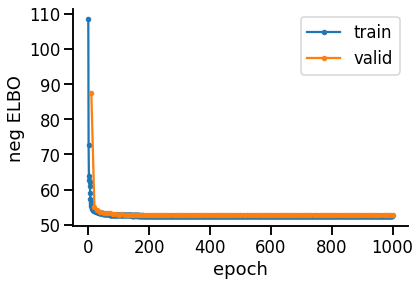

In [6]:
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(1, 1)
    ax.plot(loss_train, ".-", label="train")
    ax.plot(np.arange(1, len(loss_valid)+1) * valid_every, loss_valid, ".-", label="valid")
    ax.set(xlabel="epoch", ylabel="neg ELBO")
    ax.legend()
    sns.despine()

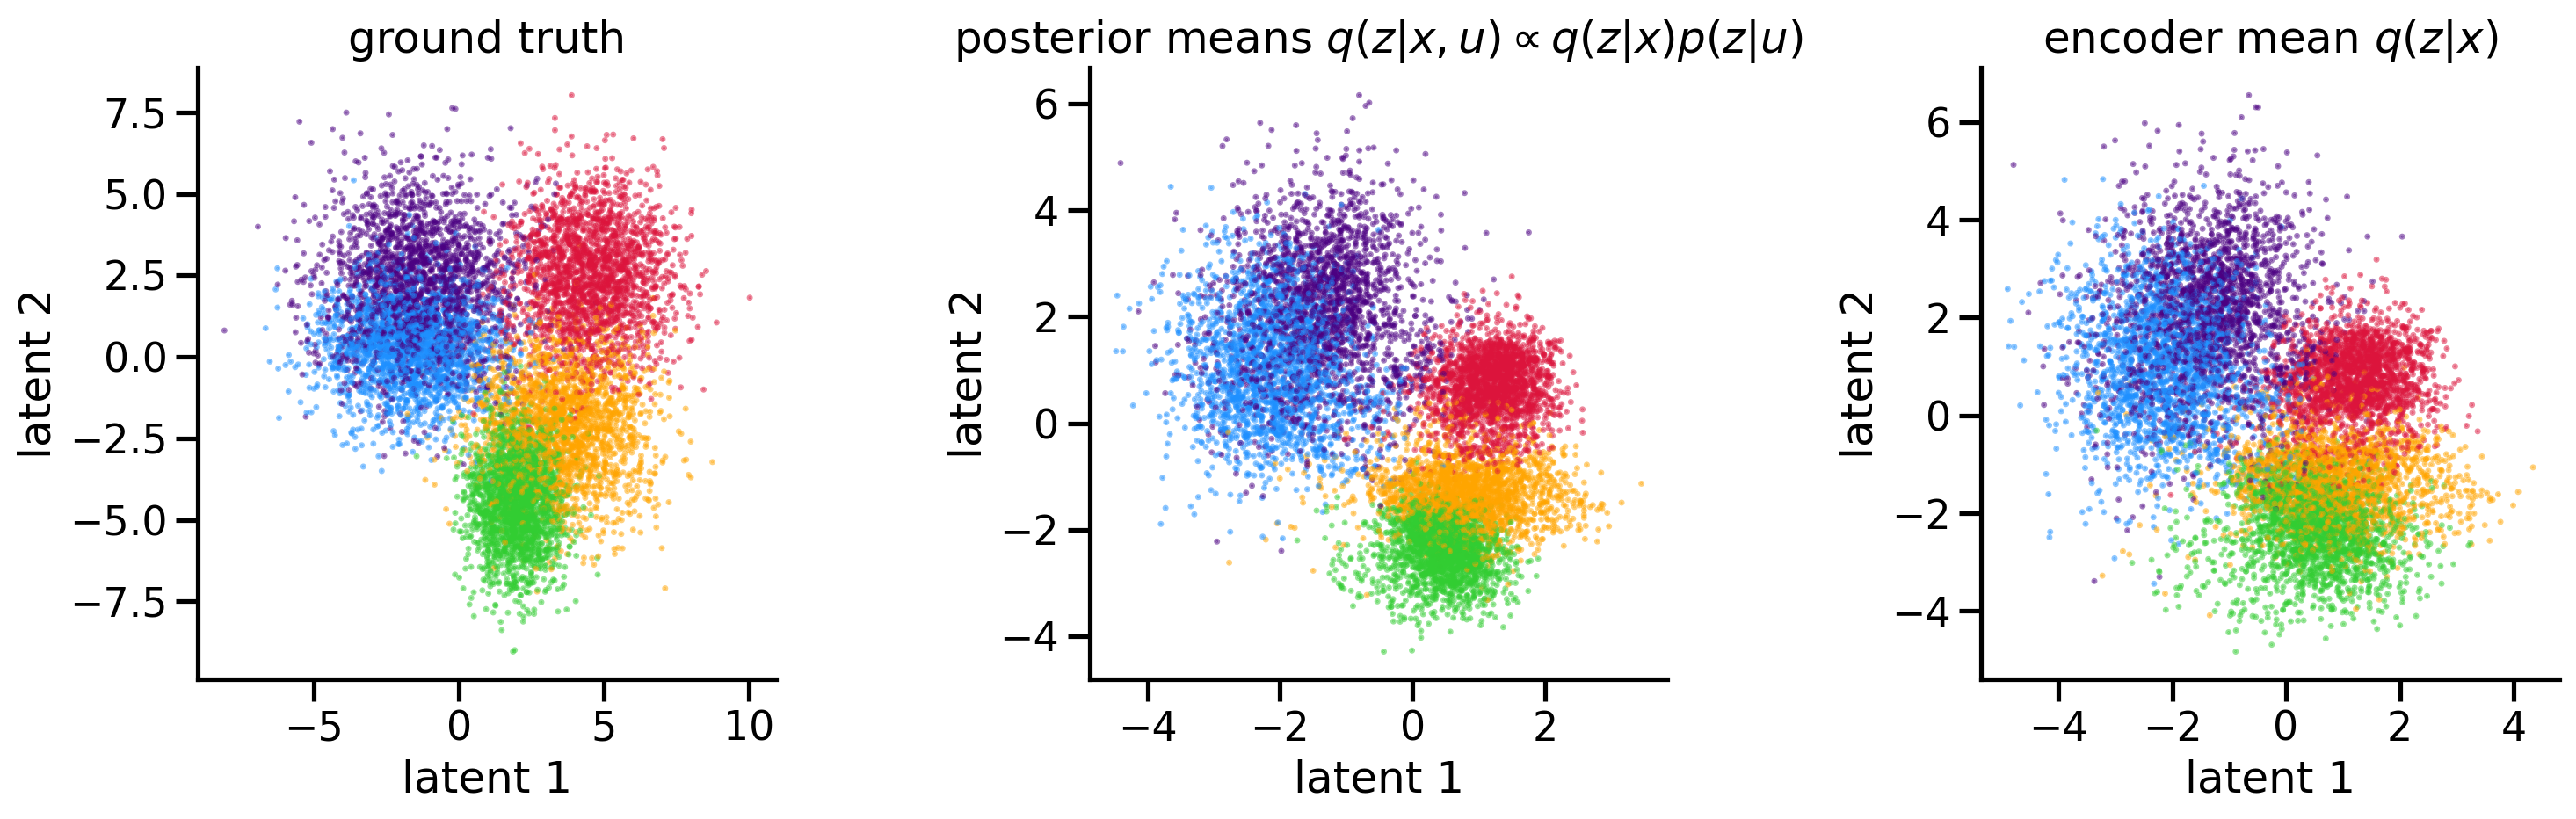

In [7]:
with torch.no_grad():
    _, out_dict = vae(x_true, u_true if discrete_prior else u_true.unsqueeze(-1), valid=True)
    post_means = out_dict["post_mean"]
    post_log_vars = out_dict["post_log_var"]
    post_lam_means = out_dict["lam_mean"]
    post_lam_log_vars = out_dict["lam_log_var"]
    z_means = out_dict["z_mean"]
    z_log_vars = out_dict["z_log_var"]

post_means = post_means.cpu()
z_means = z_means.cpu()
z_true = z_true.cpu()
u_true = u_true.cpu()
ll = n_samples

if discrete_prior:
    c_vec = np.array(['crimson','orange','dodgerblue','limegreen','indigo'])
    idx = u_true
else:
    length = 30
    c_vec = plt.cm.viridis(np.linspace(0,1, length))
    bins = np.linspace(0, 2*np.pi, length)
    centers = (bins[1:]+bins[:-1])/2
    idx = np.digitize(u_true.squeeze(), centers)

with sns.plotting_context("talk", font_scale=1):

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=200)
    ax[0].scatter(z_true[:,0], z_true[:,1], c=c_vec[idx], s=1, alpha=0.5, rasterized=True)
    ax[1].scatter(post_means[:,1], post_means[:,0], c=c_vec[idx], s=1, alpha=0.5, rasterized=True)
    ax[2].scatter(z_means[:,1], z_means[:,0], s=1, c=c_vec[idx], alpha=0.5, rasterized=True)
    
    ax[0].set(xlabel="latent 1", ylabel="latent 2", title="ground truth")
    ax[1].set(xlabel="latent 1", ylabel="latent 2", title=r"posterior means $q(z|x,u)\propto q(z|x)p(z|u)$")
    ax[2].set(xlabel="latent 1", ylabel="latent 2", title=r"encoder mean $q(z|x)$")
    fig.tight_layout()
    sns.despine()
